## Library Import

In [14]:
# Importing necessary library
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import ticker
from matplotlib import rcParams
from matplotlib.ticker import LinearLocator
import pywt
import pandas as pd
import os
import time
from scipy import signal
from stingray import lightcurve
import sys
from stingray import Bispectrum
import warnings
import csv
import random
warnings.filterwarnings('ignore')
%matplotlib inline

In [12]:
SEGMENT_TIME = 10
directory_segmented = f"datasets/segmented_{SEGMENT_TIME} seconds"

In [13]:
fs = 256
t = np.arange(0, SEGMENT_TIME, 1/(fs * SEGMENT_TIME))
t

array([0.00000000e+00, 3.90625000e-04, 7.81250000e-04, ...,
       9.99882813e+00, 9.99921875e+00, 9.99960938e+00])

## General Function

In [4]:
# file that will be skipped because of information loss
# zeros_test = ['co2a0000368_91.csv', 'co2c0000341_26.csv']
# zeros_train = ['co2a0000368_0.csv', 'co2a0000368_1.csv', 'co2a0000368_2.csv', 'co2a0000368_3.csv', 'co2a0000368_4.csv', 'co2a0000368_5.csv', 'co2c0000341_27.csv']

# Define sampling frequency
fs = 256
t = np.arange(0, 1, 1/fs)

def get_dummy(directory, lag):
    for foldername in os.listdir(directory):
        folder = os.path.join(directory, foldername)
        if os.path.isdir(folder):
            # des_dir = os.path.join(directory.replace('CSV', 'FEATURE')+"_" + str(lag),foldername).lower()
            files = os.listdir(folder)
            for filename in files:
                rel_path = os.path.join(directory, foldername, filename)
                # if 'metadata' in filename.lower():
                #     continue
                print(rel_path)
                df_data, channel_name = get_csv_EEG(rel_path)
                RWB = []
                return df_data[channel_name[2]]
                # pd.DataFrame(RWB.T).to_csv(des_path, index=False)
                
def get_csv_EEG(filename):
    # Load data from CSV
    df_data = pd.read_csv(filename)
    return df_data, df_data.columns

## RWB Visualization

In [5]:
def calcCumulantOrde3(df_data, t, lag):
    # Compute the bispectrum of the signal
    lc = lightcurve.Lightcurve(t,df_data)
    # lc.plot()
    bs = Bispectrum(lc, maxlag=lag)

    print(bs.bispec.shape)

    # Plot the bispectrum using contour plots
    plt.contour(bs.freq, bs.freq, bs.bispec_mag)
    plt.xlabel('f1')
    plt.ylabel('f2')
    plt.show()

    fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(10, 6))

    # # Make data.
    X, Y = np.meshgrid(bs.freq, bs.freq)

    # # Plot the surface.
    surf = ax.plot_surface(X, Y, bs.cum3, cmap=cm.coolwarm,
                        linewidth=0, antialiased=True)

    # # Customize the z axis.
    # # ax.set_zlim(-1.01, 1.01)
    ax.zaxis.set_major_locator(LinearLocator(10))
    # # A StrMethodFormatter is used automatically
    ax.zaxis.set_major_formatter('{x:.02f}')

    # # Add a color bar which maps values to colors.
    fig.colorbar(surf, shrink=0.5, aspect=5)

    plt.show()
    # Plot the bispectrum using mesh plots
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    X, Y = np.meshgrid(bs.freq, bs.freq)
    ax.plot_surface(X, Y, bs.cum3)
    ax.set_xlabel('f1')
    ax.set_ylabel('f2')
    ax.set_zlabel('Bispectrum')
    plt.show()

    return bs

def calcWaveletDec(bs):
    # Select wavelet and decomposition level
    wavelet = 'db4'
    level = 5

    # Deecompose signal
    coeffs = pywt.wavedec2(bs.cum3, wavelet, level=level)
    # Plot the bispectrum using mesh plots
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    X, Y = np.meshgrid(np.arange(len(coeffs[0])), np.arange(len(coeffs[0][0])))
    ax.plot_surface(X, Y, coeffs[0])
    ax.set_xlabel('f1')
    ax.set_ylabel('f2')
    ax.set_zlabel('Bispectrum')
    plt.show()

    x, y = np.meshgrid(np.arange(len(coeffs[0])), np.arange(len(coeffs[0][0])))
    z = coeffs[0]
    z = z[:-1, :-1]
    z_min, z_max = -np.abs(z).max(), np.abs(z).max()
    
    plt.subplot()
    
    plt.pcolormesh(x, y, z, 
                cmap =cm.coolwarm, 
                vmin = z_min, 
                vmax = z_max,
                edgecolors = 'face',
                shading ='flat')
    
    plt.title('Approximation')
    
    # set the limits of the plot
    # to the limits of the data
    plt.axis([x.min(), x.max(), y.min(), y.max()])
    
    plt.colorbar()
    plt.show()

    fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(10, 6))

    # # Make data.
    X, Y = np.meshgrid(np.arange(len(coeffs[0])), np.arange(len(coeffs[0][0])))

    # Plot the surface.
    surf = ax.plot_surface(X, Y, coeffs[0], cmap=cm.coolwarm,
                        linewidth=0, antialiased=False)

    # Customize the z axis.
    # ax.set_zlim(min(coeffs[0].all()), max(coeffs[0].all()))
    ax.zaxis.set_major_locator(LinearLocator(5))
    # A StrMethodFormatter is used automatically
    ax.zaxis.set_major_formatter('{x:.02f}')

    # Add a color bar which maps values to colors.
    fig.colorbar(surf, shrink=0.75, aspect=20)
    # Visualize
    plt.show()
    
    cA5 = coeffs[0][np.triu(np.ones_like(coeffs[0], dtype=bool))]
    cD5 = np.ravel([coeffs[1][0], coeffs[1][1], coeffs[1][2]])
    cD4 = np.ravel([coeffs[2][0], coeffs[2][1], coeffs[2][2]])
    cD3 = np.ravel([coeffs[3][0], coeffs[3][1], coeffs[3][2]])
    cD2 = np.ravel([coeffs[4][0], coeffs[4][1], coeffs[4][2]])
    cD1 = np.ravel([coeffs[5][0], coeffs[5][1], coeffs[5][2]])
    
    coeff = [cA5,cD5,cD4,cD3,cD2,cD1]

    plt.figure(figsize=(10, 6))
    plt.plot(np.arange(len(cA5)), cA5, color = 'k', linewidth=1)
    plt.title(f'Approximation - Level 5')
    plt.show()
    
    plt.figure(figsize=(10, 6))
    plt.plot(np.arange(len(cD5)), cD5, color = 'k', linewidth=1)
    plt.title(f'Detail - Level 5')
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(np.arange(len(cD4)), cD4, color = 'k', linewidth=1)
    plt.title(f'Detail - Level 4')
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(np.arange(len(cD3)), cD3, color = 'k', linewidth=1)
    plt.title(f'Detail - Level 3')
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(np.arange(len(cD2)), cD2, color = 'k', linewidth=1)
    plt.title(f'Detail - Level 2')
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(np.arange(len(cD1)), cD1, color = 'k', linewidth=1)
    plt.title(f'Detail - Level 1')
    plt.show()


    return coeffs


def calcRelativeEnergy(coeffs, df_data):
    # Calculate relative wavelet energy
    energies = []
    for c in coeffs:
        energies.append(np.sum(np.square(c)))

    decomp = ['A5', 'D1', 'D2', 'D3', 'D4', 'D5']

    energies[1:6] = energies[-1:-6:-1]

    total_energy = np.sum(energies)
    relative_energies = [(e / total_energy) * 100 for e in energies]

    print(relative_energies)

    plt.figure(figsize=(10,5))
    plt.plot(decomp, energies)
    plt.xlabel('Dimension Number')
    plt.ylabel('Wavelet Bispectrum Energy')
    plt.show()
    plt.figure(figsize=(10,5))
    plt.plot(decomp, relative_energies, color = 'k', linewidth=1)
    plt.xlabel('Dimension Number')
    plt.ylabel('Relative Wavelet Bispectrum Energy')
    plt.show()

    return energies, relative_energies

### Run Vis

datasets/segmented_1 seconds\autism\Bader\segment_1.csv
(513, 513)


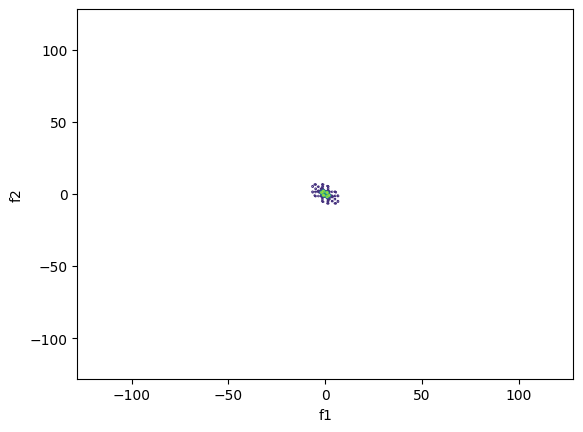

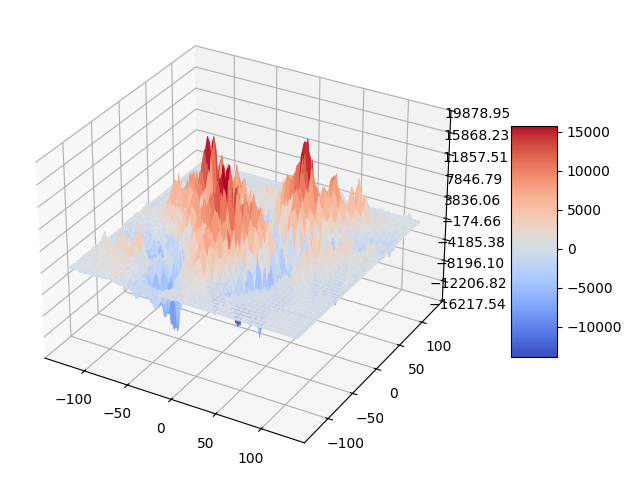

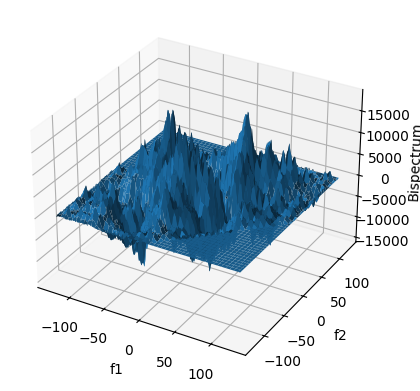

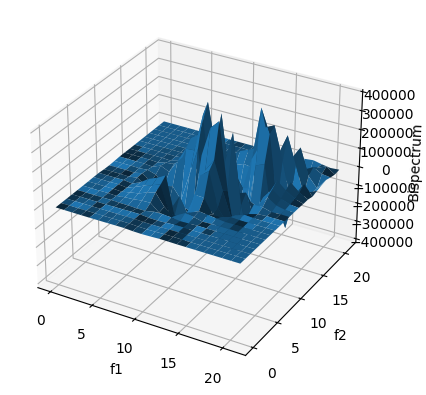

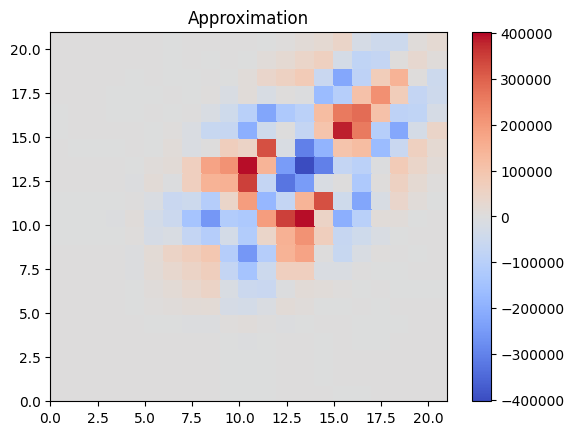

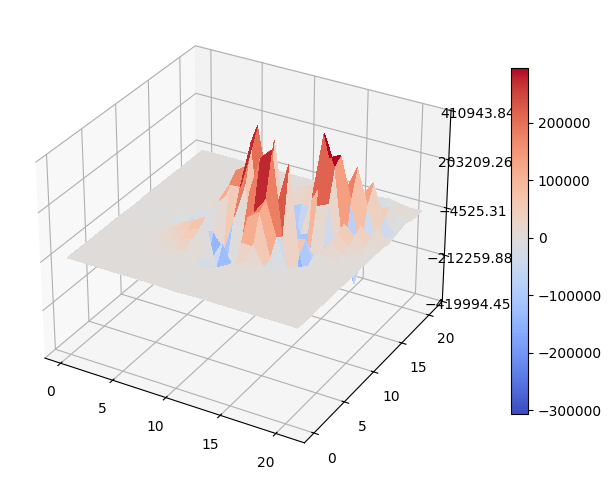

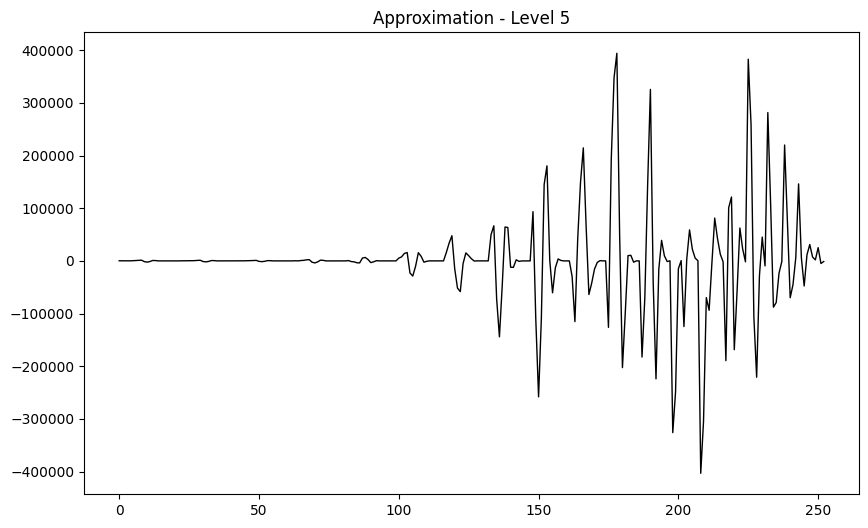

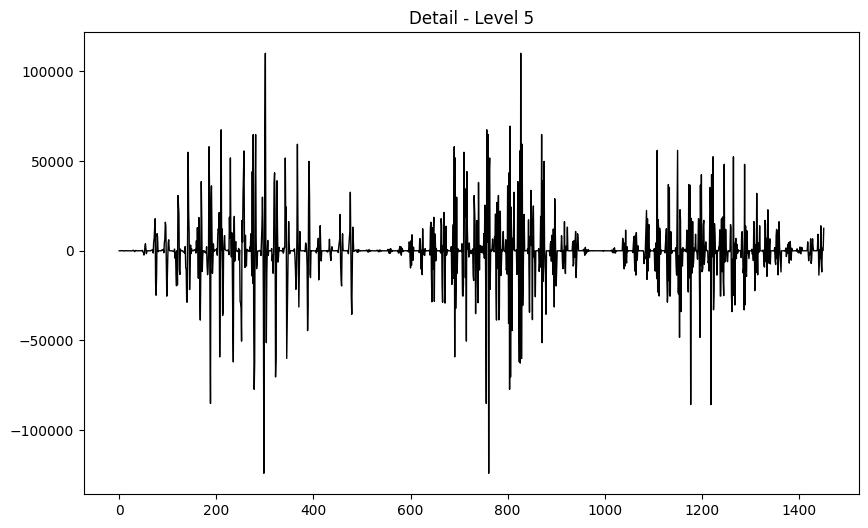

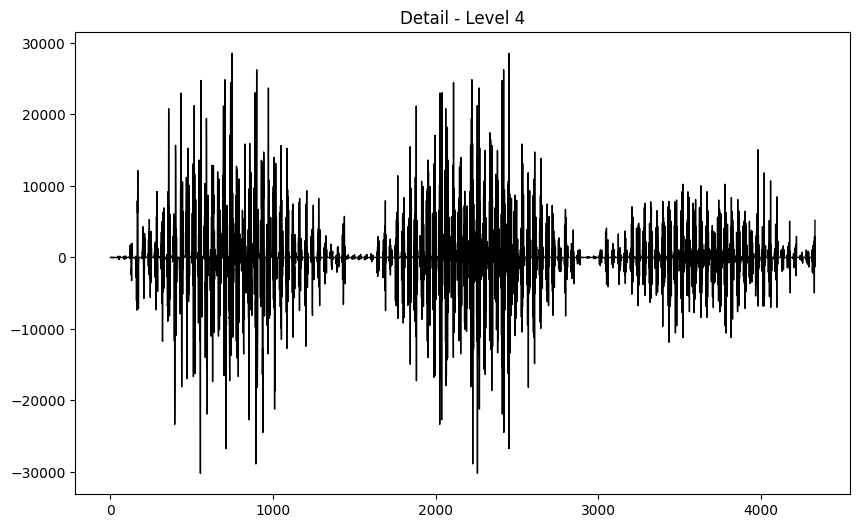

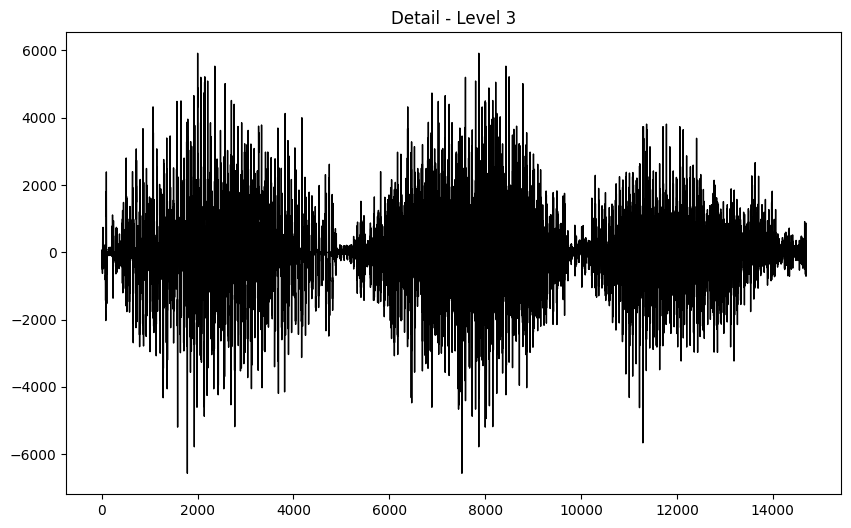

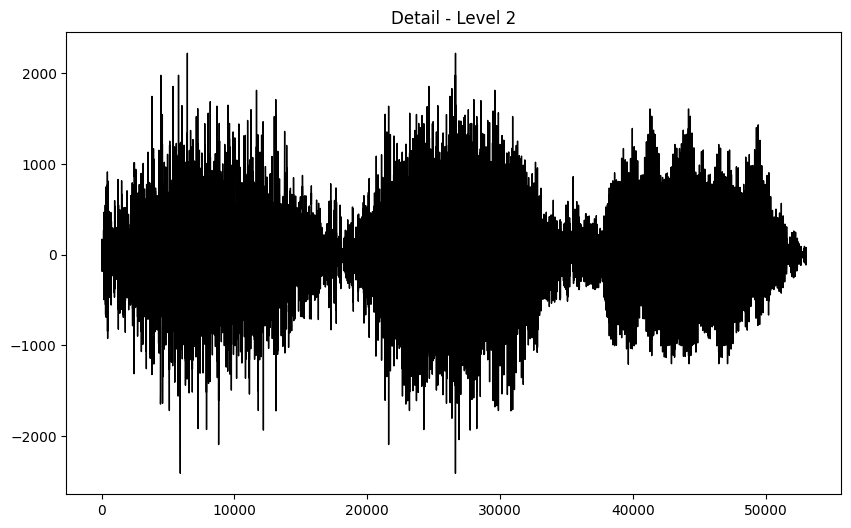

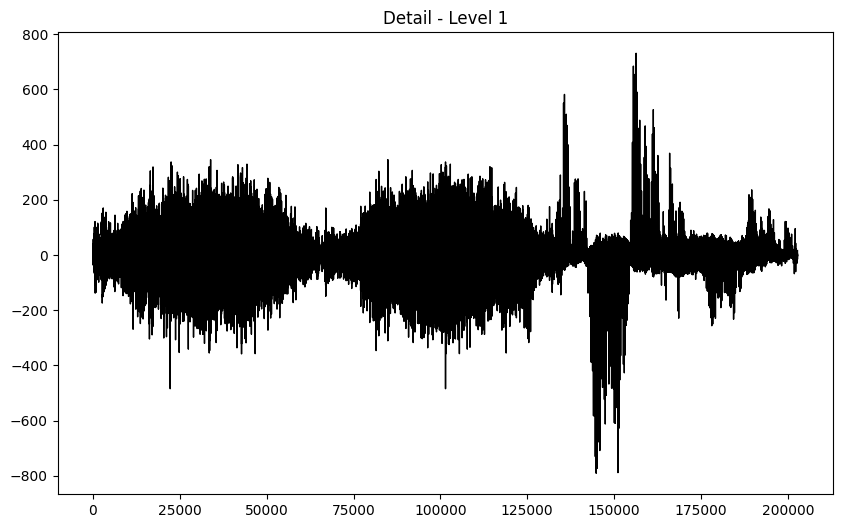

[85.47146085382295, 0.013393430306035469, 0.15863333946391905, 0.3923710256623491, 2.6130290412806403, 11.351112309464108]


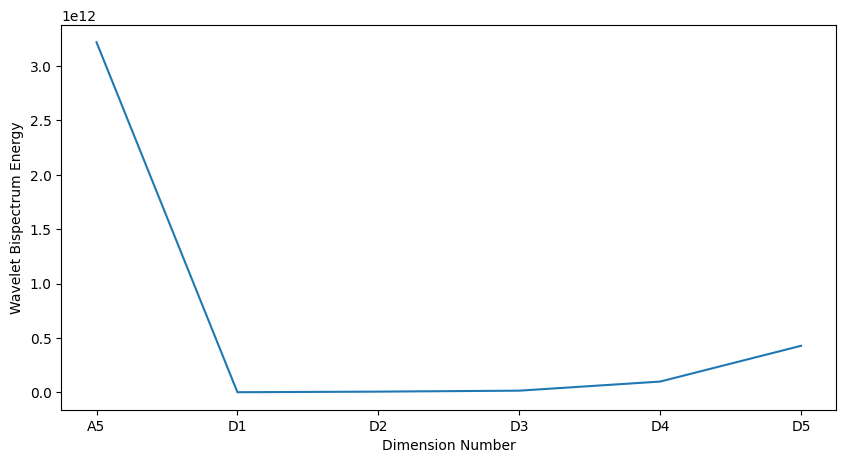

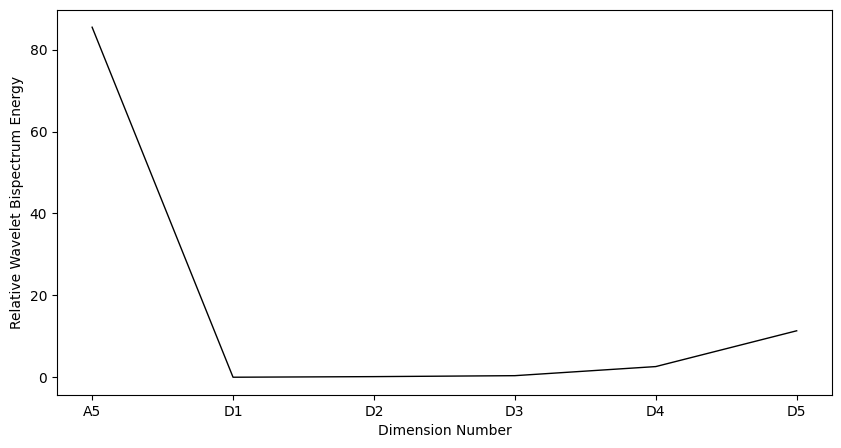

In [6]:
lag = 256

dummy = get_dummy(os.path.join(directory_segmented, "autism"), lag)
relative_energies = calcRelativeEnergy(calcWaveletDec(calcCumulantOrde3(dummy, t, lag)), dummy)

datasets/segmented_1 seconds\normal\Amer\segment_1.csv
(513, 513)


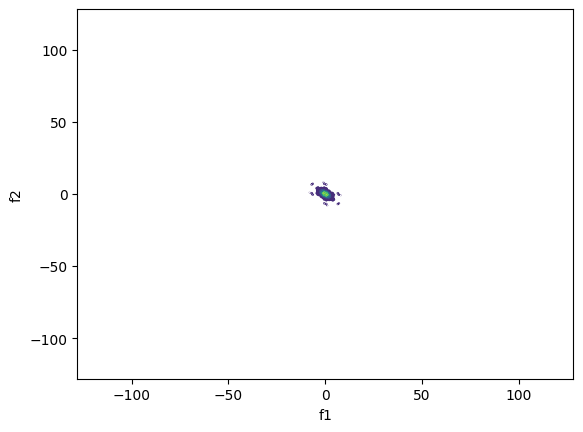

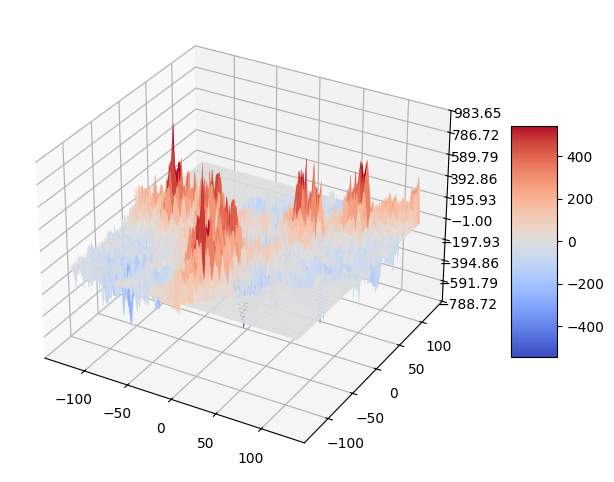

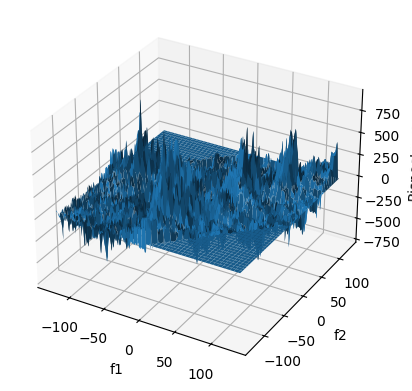

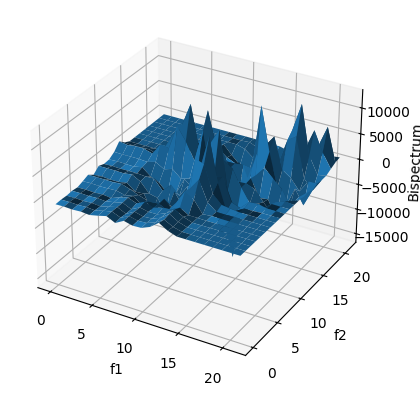

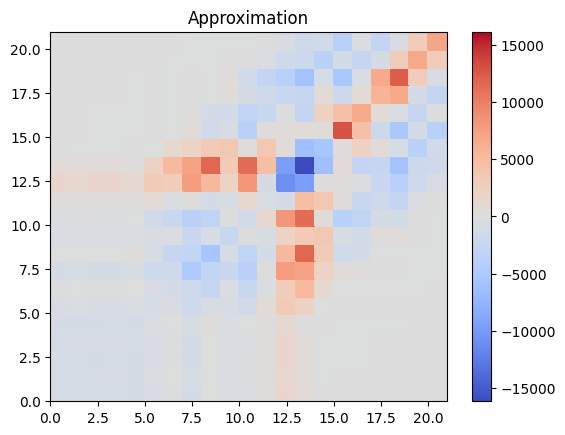

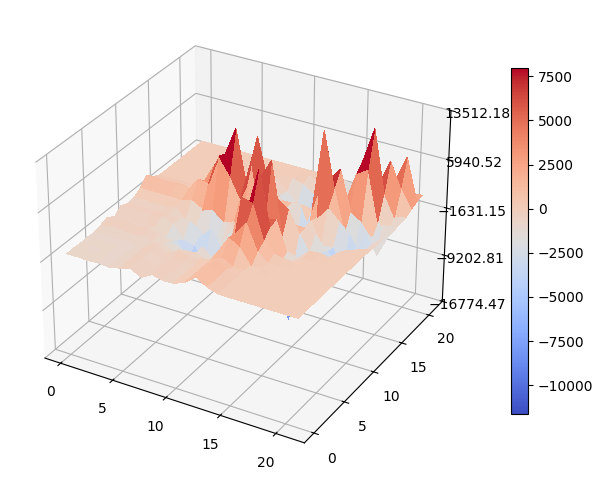

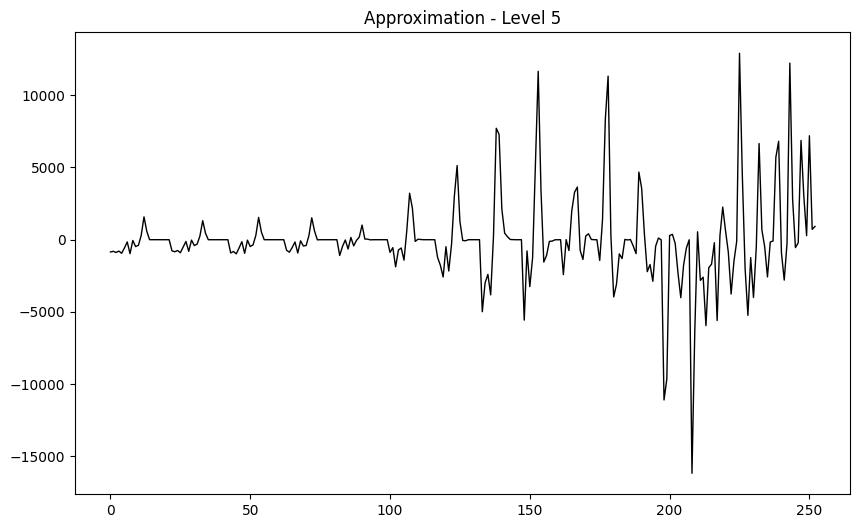

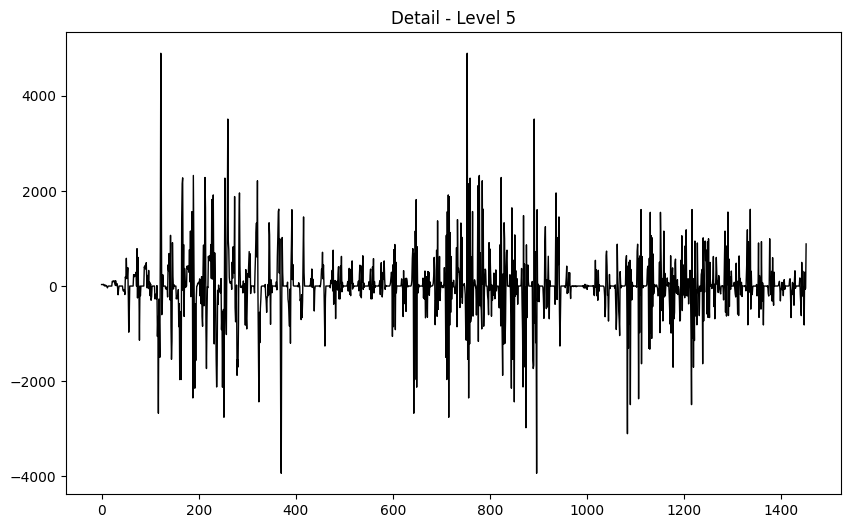

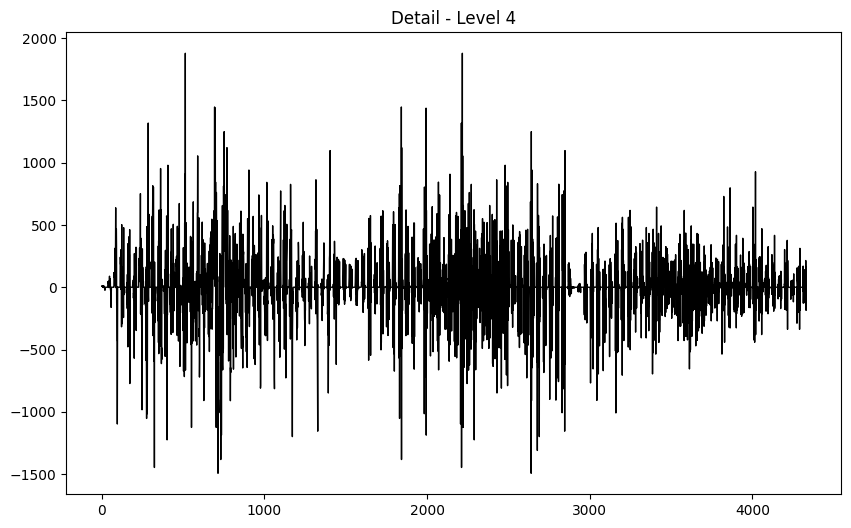

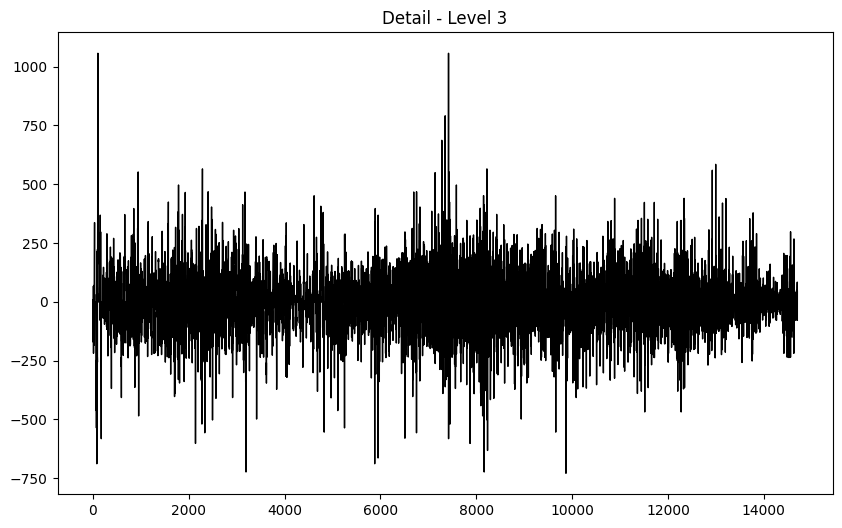

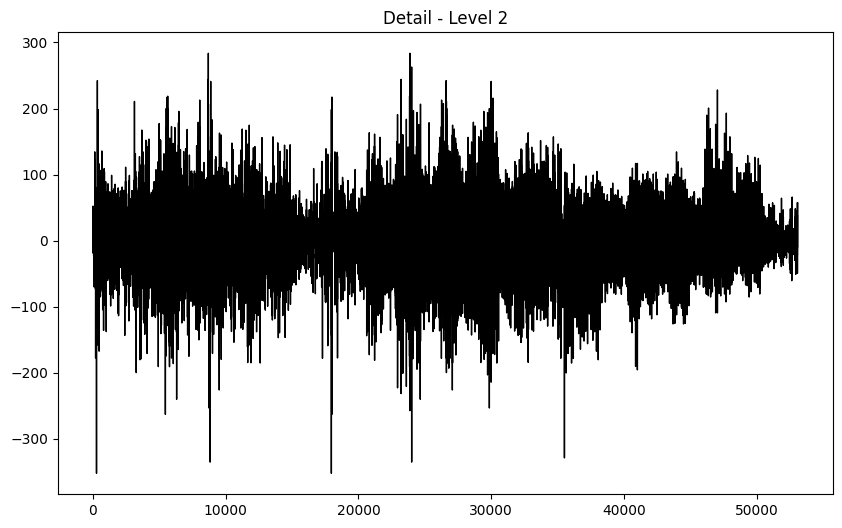

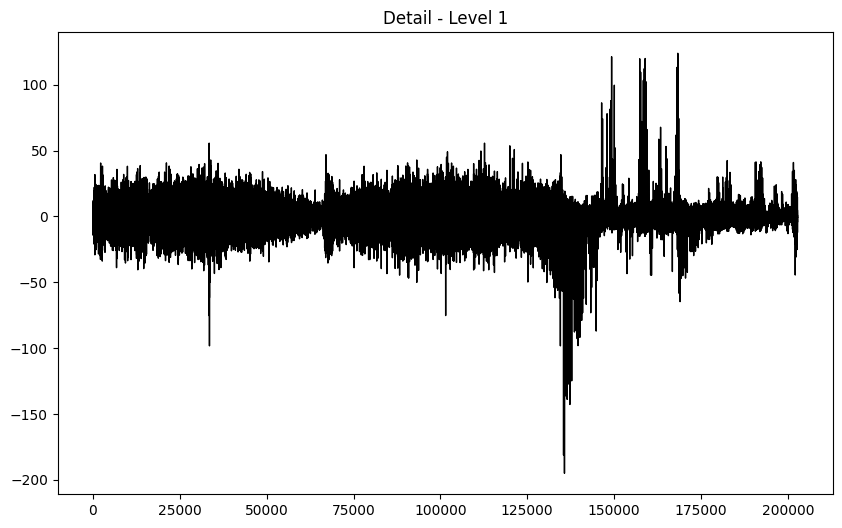

[72.79802044149942, 0.21663241000238906, 1.687265404919955, 3.441276363676713, 6.717782573576946, 15.139022806324581]


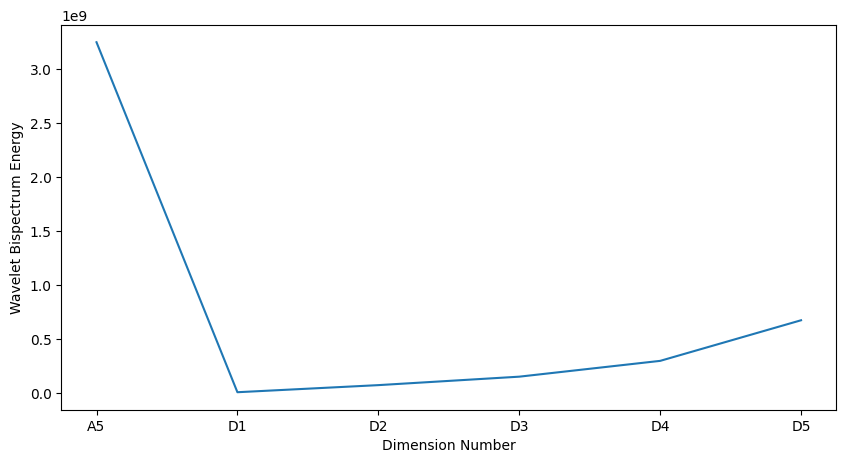

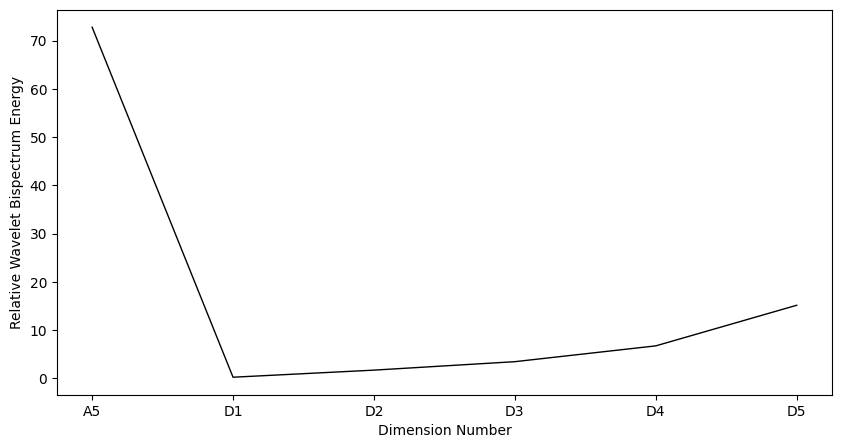

In [7]:
lag = 256

dummy = get_dummy(os.path.join(directory_segmented, "normal"), lag)
relative_energies = calcRelativeEnergy(calcWaveletDec(calcCumulantOrde3(dummy, t, lag)), dummy)

## Bispectrum Visualization

In [8]:
def calcBispec(df_data, t, lag):
    # Compute the bispectrum of the signal
    lc = lightcurve.Lightcurve(t,df_data.T)
    bs = Bispectrum(lc, maxlag=lag)

    x, y = np.meshgrid(bs.freq, bs.freq)
    z = bs.bispec_mag
    z = z[:-1, :-1]
    z_min, z_max = 0, np.abs(z).max()
    plt.subplot()

    plt.pcolormesh(x, y, z, 
                cmap =cm.coolwarm, 
                vmin = z_min, 
                vmax = z_max,
                edgecolors = 'face',
                shading ='flat')

    plt.title('Bispectrum')

    # set the limits of the plot
    # to the limits of the data
    plt.axis([x.min(), x.max(), y.min(), y.max()])

    plt.colorbar()
    plt.show()

    # Plot the bispectrum using mesh plots
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(111, projection='3d')
    # plt.subplots_adjust(right=2)
    ax.zaxis.set_major_formatter(ticker.EngFormatter(unit=''))
    X, Y = np.meshgrid(bs.freq, bs.freq)
    ax.plot_surface(X, Y, bs.bispec_mag, cmap =cm.coolwarm)
    ax.set_xlabel('f1')
    ax.set_ylabel('f2')
    plt.show()

    temp = bs.bispec_mag[:lag, :lag]
    freq_temp = bs.freq[:lag]

    # Plot the bispectrum using contourf plots
    x, y = np.meshgrid(freq_temp, freq_temp)
    z = temp
    z = z[:-1, :-1]
    z_min, z_max = 0, np.abs(z).max()
    plt.subplot()

    plt.pcolormesh(x, y, z, 
                cmap =cm.coolwarm, 
                vmin = z_min, 
                vmax = z_max,
                edgecolors = 'face',
                shading ='flat')

    plt.title('Bispectrum kuadran 4')

    # set the limits of the plot
    # to the limits of the data
    plt.axis([x.min(), x.max(), y.min(), y.max()])

    plt.colorbar()
    plt.show()

    # Plot the bispectrum using mesh plots
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(111, projection='3d')
    ax.zaxis.set_major_formatter(ticker.EngFormatter(unit=''))
    X, Y = np.meshgrid(freq_temp, freq_temp)
    ax.plot_surface(X, Y, temp, cmap =cm.coolwarm)
    ax.set_xlabel('f1')
    ax.set_ylabel('f2')
    plt.show()

    temp2 = temp[(lag//2)+30:, (lag//2)+30:]
    freq_temp2 = freq_temp[(lag//2)+30:]

    # Plot the bispectrum using contourf plots
    x, y = np.meshgrid(freq_temp2, freq_temp2)
    z = temp2
    z = z[:-1, :-1]
    z_min, z_max = 0, np.abs(z).max()
    plt.subplot()

    plt.pcolormesh(x, y, z, 
                cmap =cm.coolwarm, 
                vmin = z_min, 
                vmax = z_max,
                edgecolors = 'face',
                shading ='flat')

    plt.title('Bispectrum kuadran 4')

    # set the limits of the plot
    # to the limits of the data
    plt.axis([x.min(), x.max(), y.min(), y.max()])

    plt.colorbar()
    plt.show()

    # Plot the bispectrum using mesh plots
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(111, projection='3d')
    ax.zaxis.set_major_formatter(ticker.EngFormatter(unit=''))
    X, Y = np.meshgrid(freq_temp2, freq_temp2)
    ax.plot_surface(X, Y, temp2, cmap =cm.coolwarm)
    ax.set_xlabel('f1')
    ax.set_ylabel('f2')
    plt.show()

    return bs.bispec_mag

def gkernel(k=2, l=1, sig=20):
    """
    Gaussian Kernel Creator via given length and sigma
    """

    ax = np.linspace(-(l - 1) / 2., (l - 1) / 2., l)
    bx = np.linspace(-(k - 1) / 2., (k - 1) / 2., k)

    xx, yy = np.meshgrid(ax, bx)

    kernel = np.exp(-0.5 * (np.square(xx) + np.square(yy)) / np.square(sig))

    return kernel / np.max(kernel)

def create_feature(bispectrum, pyramid, fil_size, bis_dim):
    fsize = len(fil_size)
    feature_matrix = np.zeros([fsize,fsize])
    filtered_array = np.zeros([bis_dim,bis_dim])
    xtrack = 0
    ytrack = 0
    for xdim in range(fsize):
        for ydim in range(fsize):
            x,y = fil_size[xdim], fil_size[ydim]
            filtered_array[xtrack:xtrack+x, ytrack:ytrack+y] = bispectrum[xtrack:xtrack+x, ytrack:ytrack+y] * pyramid[xtrack:xtrack+x, ytrack:ytrack+y]
            feature_matrix[xdim][ydim] = np.mean(filtered_array[xtrack:xtrack+x, ytrack:ytrack+y])
            ytrack = ytrack+y
        ytrack = 0
        xtrack = xtrack+x
    # final_feature = feature_matrix[np.triu(np.ones_like(feature_matrix, dtype=bool))]
    # final_feature = final_feature[~np.isnan(final_feature)]

    final_feature = feature_matrix.flatten()
    

    # FILTER
    x, y = np.meshgrid(np.arange(bis_dim), np.arange(bis_dim))
    z = pyramid
    z = z[:-1, :-1]
    z_min, z_max = 0, np.abs(z).max()
    plt.subplot()

    plt.pcolormesh(x, y, z, 
                cmap =cm.coolwarm, 
                vmin = z_min, 
                vmax = z_max,
                edgecolors = 'face',
                shading ='flat')

    plt.title('Filter')

    # set the limits of the plot
    # to the limits of the data
    plt.axis([x.min(), x.max(), y.min(), y.max()])

    plt.colorbar()
    plt.show()

    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(111, projection='3d')
    # ax.zaxis.set_major_formatter(ticker.EngFormatter(unit=''))
    X, Y = np.meshgrid(np.arange(bis_dim), np.arange(bis_dim))
    ax.plot_surface(X, Y, pyramid, cmap =cm.coolwarm)
    ax.set_xlabel('f1')
    ax.set_ylabel('f2')
    plt.show()

    # FILTERED MATRIX
    x, y = np.meshgrid(np.arange(bis_dim), np.arange(bis_dim))
    z = filtered_array
    z = z[:-1, :-1]
    z_min, z_max = 0, np.abs(z).max()
    plt.subplot()

    plt.pcolormesh(x, y, z, 
                cmap =cm.coolwarm, 
                vmin = z_min, 
                vmax = z_max,
                edgecolors = 'face',
                shading ='flat')

    plt.title('Filtered Matrix')

    # set the limits of the plot
    # to the limits of the data
    plt.axis([x.min(), x.max(), y.min(), y.max()])

    plt.colorbar()
    plt.show()

    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(111, projection='3d')
    # ax.zaxis.set_major_formatter(ticker.EngFormatter(unit=''))
    X, Y = np.meshgrid(np.arange(bis_dim), np.arange(bis_dim))
    ax.zaxis.set_major_formatter(ticker.EngFormatter(unit=''))
    ax.plot_surface(X, Y, filtered_array, cmap =cm.coolwarm)
    ax.set_xlabel('f1')
    ax.set_ylabel('f2')
    plt.show()

    # ZOOMED RESULT

    temp = filtered_array[(lag//2)+30:, (lag//2)+30:]

    x, y = np.meshgrid(np.arange(len(temp)), np.arange(len(temp)))
    z = temp
    z = z[:-1, :-1]
    z_min, z_max = 0, np.abs(z).max()
    plt.subplot()

    plt.pcolormesh(x, y, z, 
                cmap =cm.coolwarm, 
                vmin = z_min, 
                vmax = z_max,
                edgecolors = 'face',
                shading ='flat')

    plt.title('Filtered Matrix')

    # set the limits of the plot
    # to the limits of the data
    plt.axis([x.min(), x.max(), y.min(), y.max()])

    plt.colorbar()
    plt.show()

    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(111, projection='3d')
    # ax.zaxis.set_major_formatter(ticker.EngFormatter(unit=''))
    X, Y = np.meshgrid(np.arange(len(temp)), np.arange(len(temp)))
    ax.zaxis.set_major_formatter(ticker.EngFormatter(unit=''))
    ax.plot_surface(X, Y, temp, cmap =cm.coolwarm)
    ax.set_xlabel('f1')
    ax.set_ylabel('f2')
    plt.show()

    # FEATURE MATRIX
    x, y = np.meshgrid(np.arange(fsize), np.arange(fsize))
    z = feature_matrix
    z = z[:-1, :-1]
    z_min, z_max = 0, np.abs(z).max()
    print(z_max)
    plt.subplot()

    plt.pcolormesh(x, y, z, 
                cmap =cm.coolwarm, 
                vmin = z_min, 
                vmax = z_max,
                edgecolors = 'face',
                shading ='flat')

    plt.title('Feature Matrix')

    # set the limits of the plot
    # to the limits of the data
    plt.axis([x.min(), x.max(), y.min(), y.max()])

    plt.colorbar()
    plt.show()

    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(111, projection='3d')
    # ax.zaxis.set_major_formatter(ticker.EngFormatter(unit=''))
    X, Y = np.meshgrid(np.arange(fsize), np.arange(fsize))
    print(X,Y)
    ax.plot_surface(X, Y, feature_matrix, cmap =cm.coolwarm)
    # ax.xaxis.set_major_locator(LinearLocator(5))
    # ax.yaxis.set_major_locator(LinearLocator(5))
    ax.set_xlabel('f1')
    ax.set_ylabel('f2')
    plt.show()

    # FINAL FEATURE
    t = range(len(final_feature))

    plt.figure(figsize=(10,6))
    plt.plot(t, final_feature, color = 'k', linewidth=1)
    plt.title('Final Feature')
    plt.show()

    return final_feature


### Run Visualization

datasets/segmented_1 seconds\autism\Bader\segment_1.csv


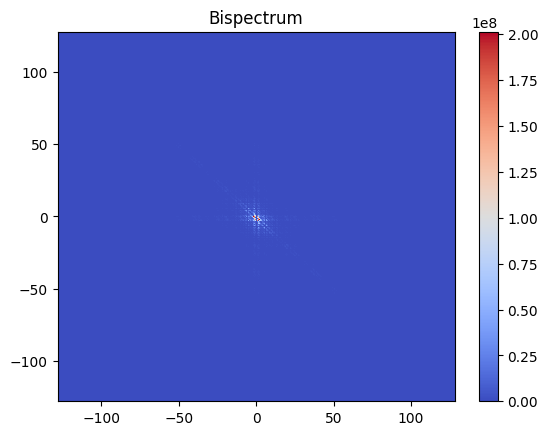

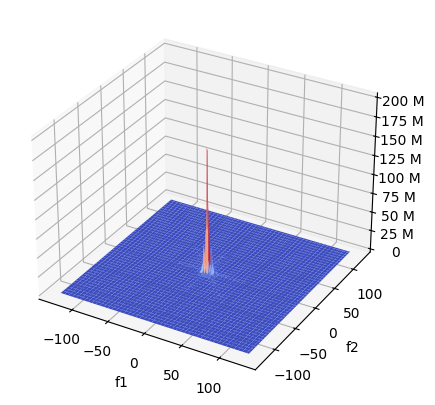

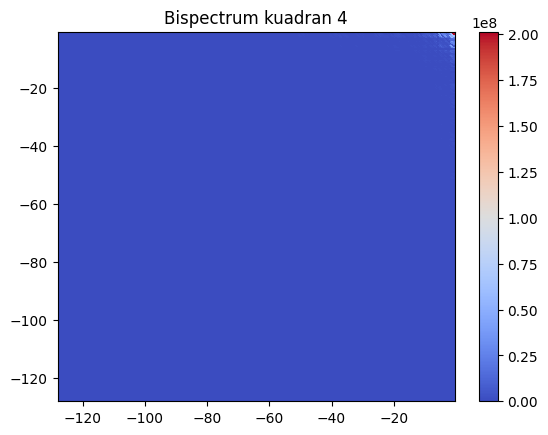

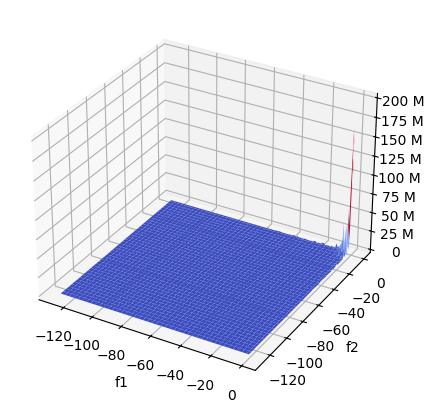

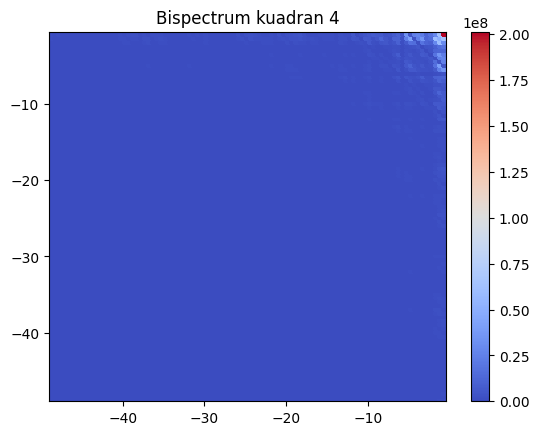

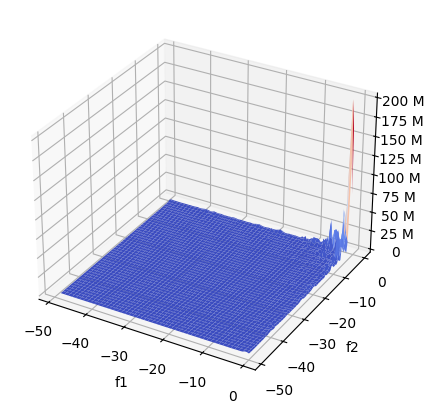

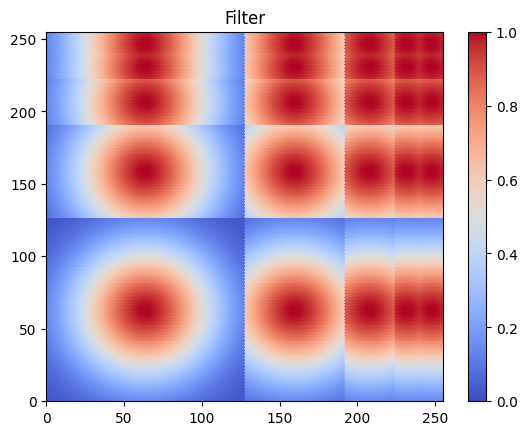

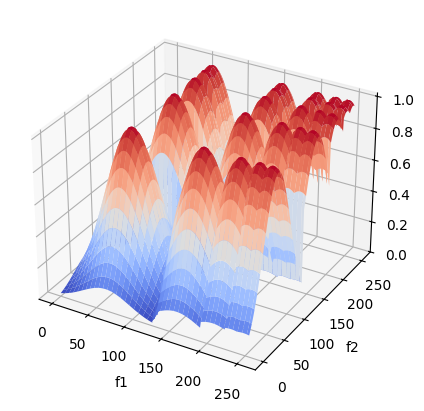

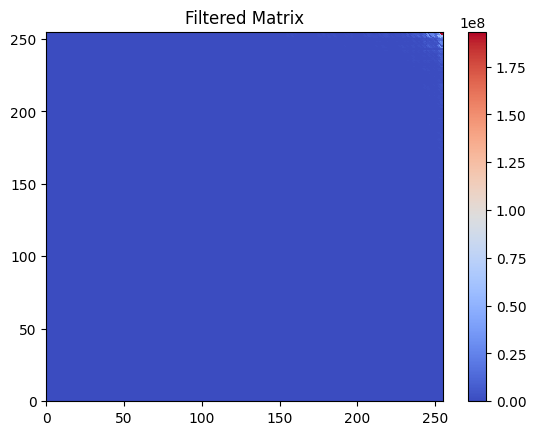

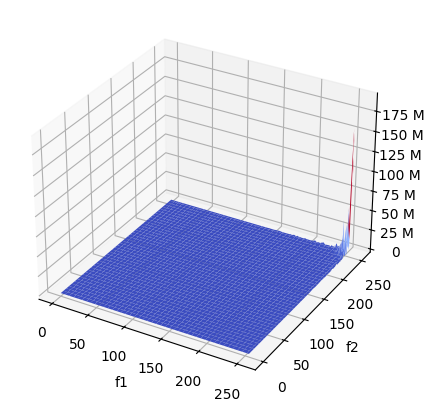

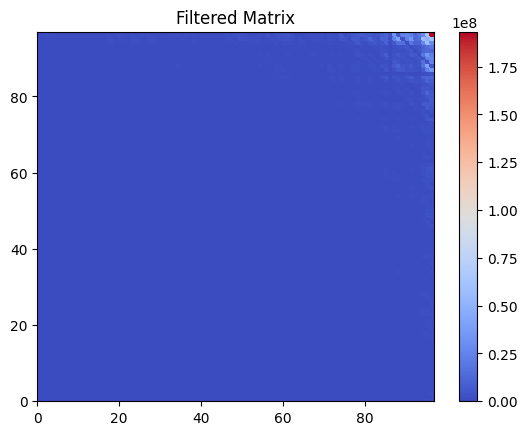

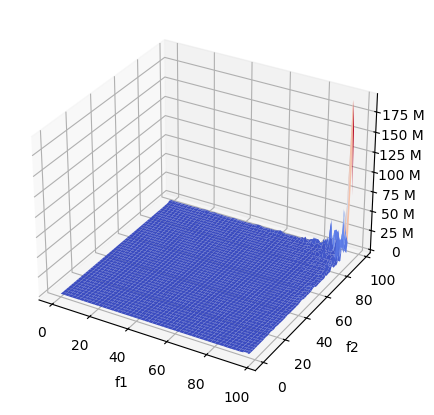

207105.72447779158


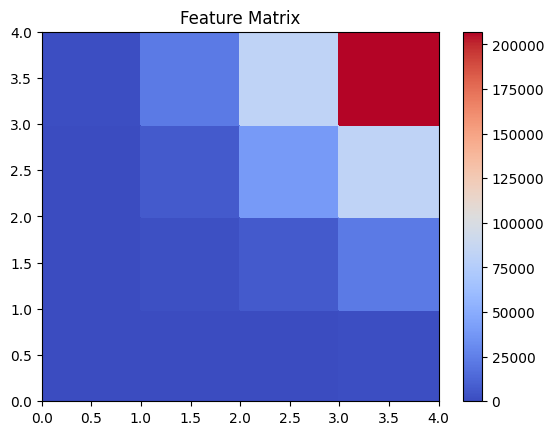

[[0 1 2 3 4]
 [0 1 2 3 4]
 [0 1 2 3 4]
 [0 1 2 3 4]
 [0 1 2 3 4]] [[0 0 0 0 0]
 [1 1 1 1 1]
 [2 2 2 2 2]
 [3 3 3 3 3]
 [4 4 4 4 4]]


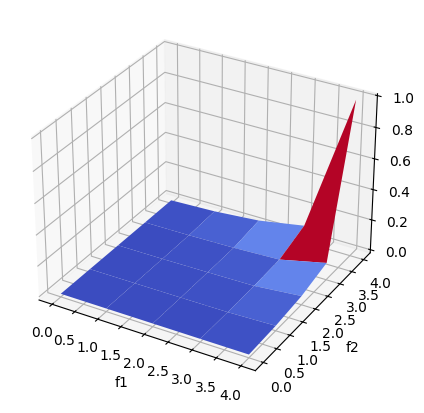

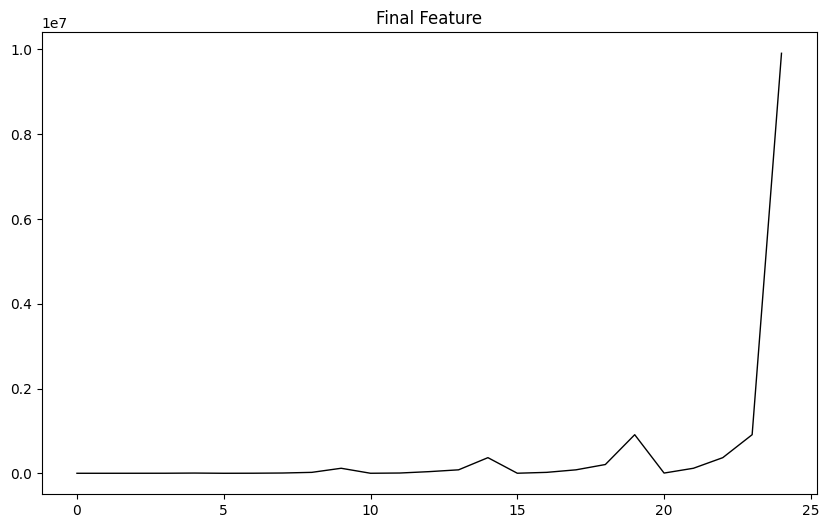

In [9]:
lag = 256
bis_dim = lag
big_fil_size = bis_dim //2
sigma = bis_dim//8
if sigma == 0:
    sigma = 1
fil_size = [big_fil_size // (2 ** i) for i in range(5)]

if sum(fil_size) != bis_dim:
        fil_size = [value for value in fil_size if value != 0]
        if len(fil_size) == 1:
            fil_size.append(fil_size[0])

fil_size[-1] = fil_size[-2] 
pyramid = np.zeros([bis_dim,bis_dim])
xtrack, ytrack = 0,0
for xdim in range(len(fil_size)):
    for ydim in range(len(fil_size)):
        x,y = fil_size[xdim], fil_size[ydim]
        pyramid[xtrack:xtrack+x, ytrack:ytrack+y] = gkernel(x, y, sigma)
        ytrack = ytrack+y
    ytrack = 0
    xtrack = xtrack+x
magnitude = calcBispec(get_dummy(os.path.join(directory_segmented, "autism"), lag), t, lag)
magnitude = magnitude[:256, :256]
feature = create_feature(magnitude,pyramid,fil_size, lag)

datasets/segmented_1 seconds\normal\Amer\segment_1.csv


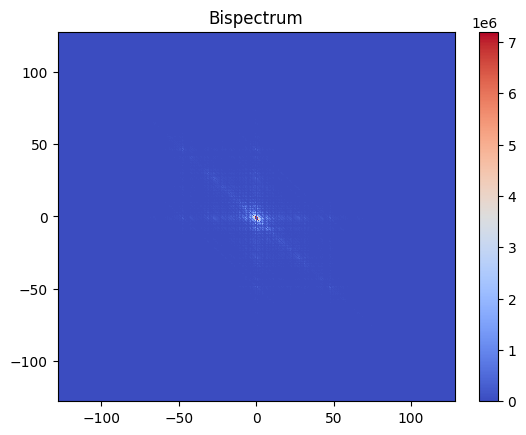

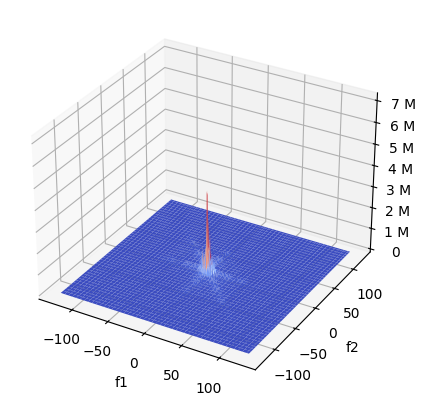

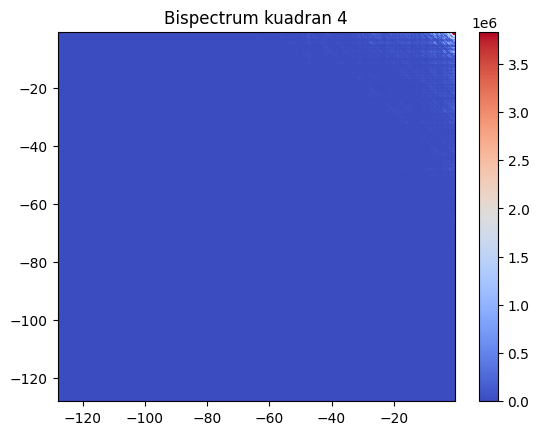

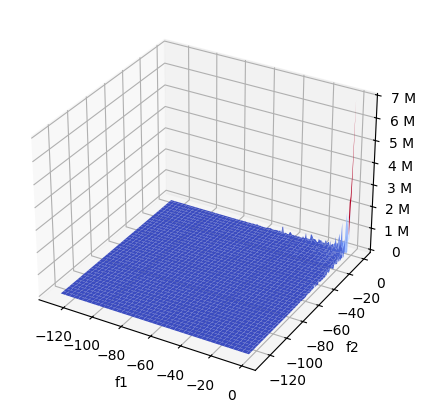

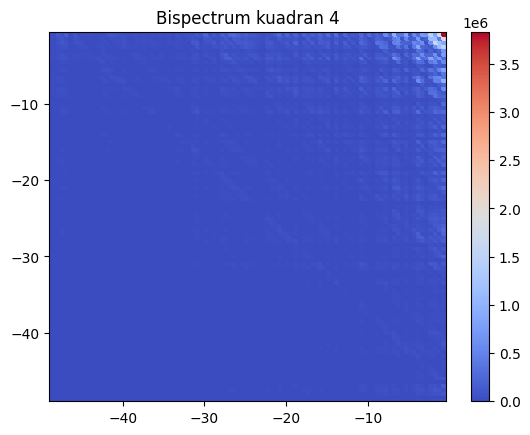

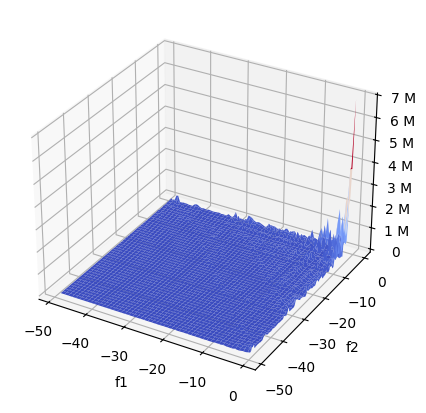

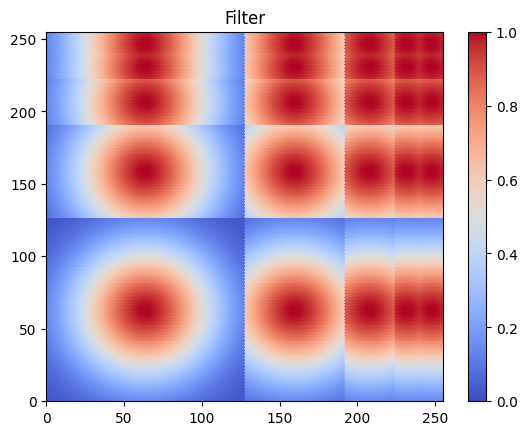

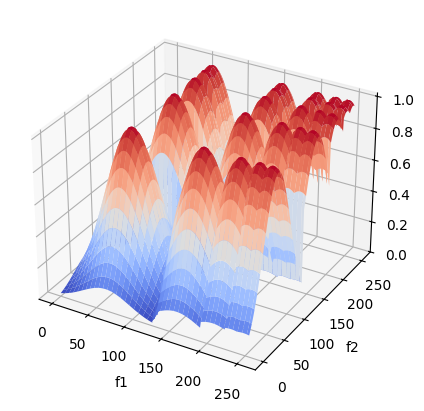

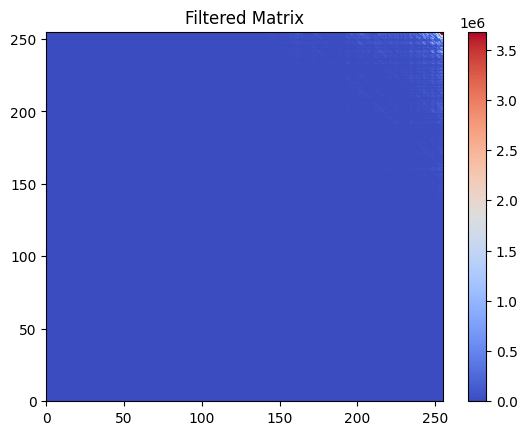

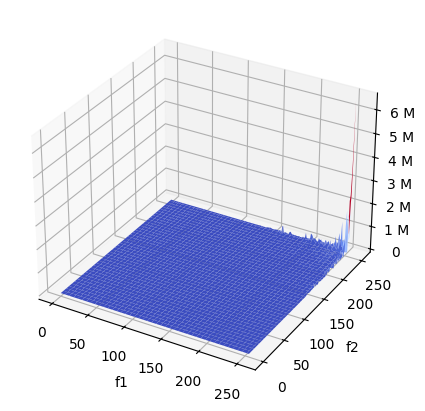

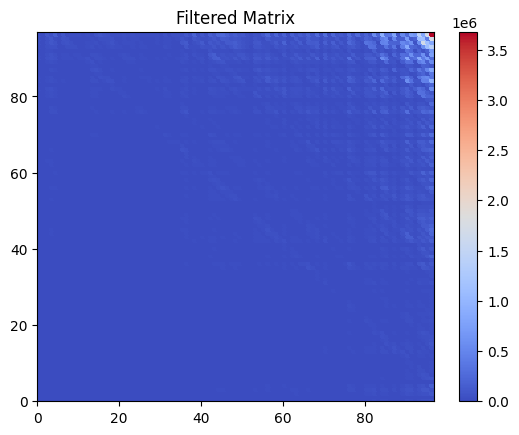

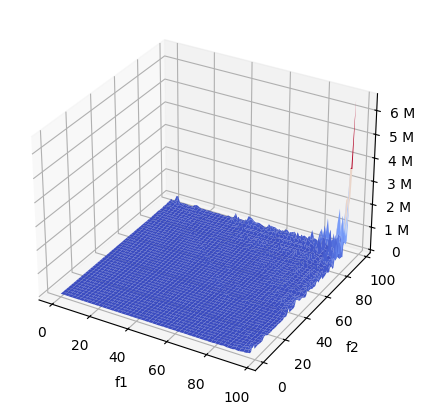

24933.293846578184


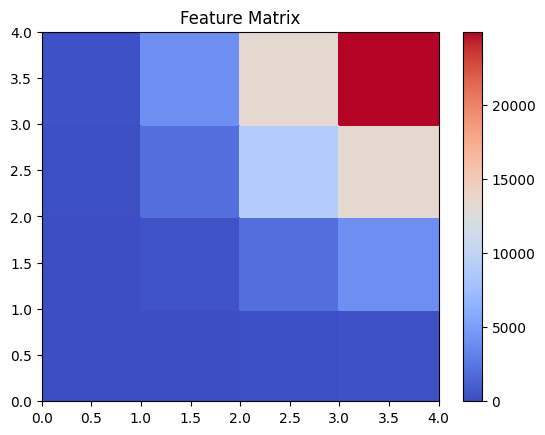

[[0 1 2 3 4]
 [0 1 2 3 4]
 [0 1 2 3 4]
 [0 1 2 3 4]
 [0 1 2 3 4]] [[0 0 0 0 0]
 [1 1 1 1 1]
 [2 2 2 2 2]
 [3 3 3 3 3]
 [4 4 4 4 4]]


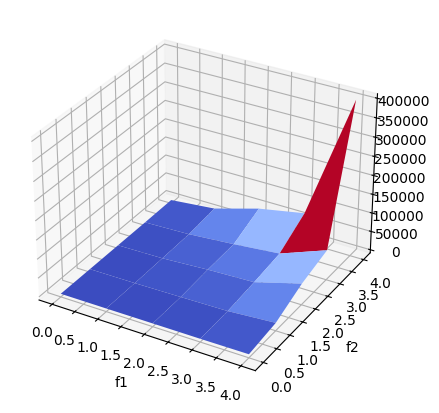

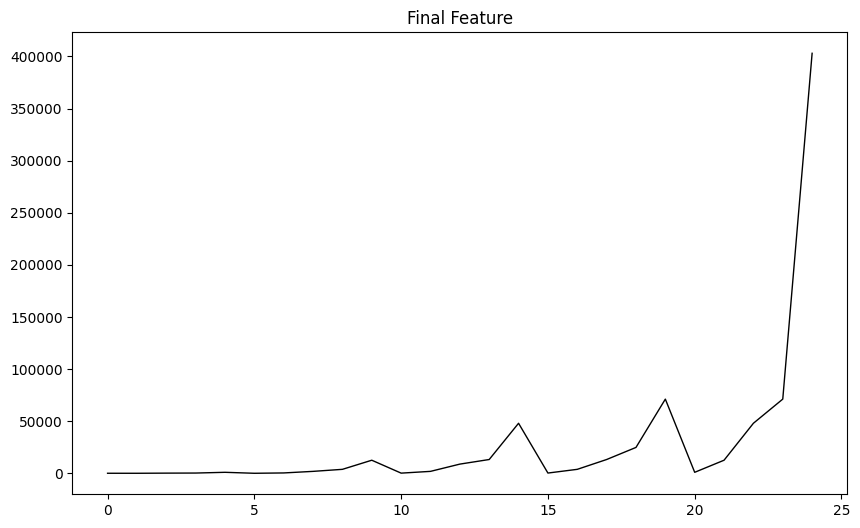

In [10]:
lag = 256
bis_dim = lag
big_fil_size = bis_dim //2
sigma = bis_dim//8
if sigma == 0:
    sigma = 1
fil_size = [big_fil_size // (2 ** i) for i in range(5)]

if sum(fil_size) != bis_dim:
        fil_size = [value for value in fil_size if value != 0]
        if len(fil_size) == 1:
            fil_size.append(fil_size[0])

fil_size[-1] = fil_size[-2] 
pyramid = np.zeros([bis_dim,bis_dim])
xtrack, ytrack = 0,0
for xdim in range(len(fil_size)):
    for ydim in range(len(fil_size)):
        x,y = fil_size[xdim], fil_size[ydim]
        pyramid[xtrack:xtrack+x, ytrack:ytrack+y] = gkernel(x, y, sigma)
        ytrack = ytrack+y
    ytrack = 0
    xtrack = xtrack+x
magnitude = calcBispec(get_dummy(os.path.join(directory_segmented, "normal"), lag), t, lag)
magnitude = magnitude[:256, :256]
feature = create_feature(magnitude,pyramid,fil_size, lag)

## Feature Visualization

In [15]:
def get_dummy(directory):
    names = random.choice(os.listdir(directory))
    files = os.listdir(os.path.join(directory, names))
    # Take random sample file in the folder
    rel_path = os.path.join(directory, names, random.choice(files))
    print(rel_path)
    signal = np.load(rel_path)
    return signal

In [18]:
SEGMENT_TIME = 1
LAG = 256

#### Bispectrum: Gaussian Kernel Filter

In [20]:
autism_dir = f"datasets/features/bispectrum/segment_{SEGMENT_TIME} seconds/autism_{LAG}"
signal = get_dummy(autism_dir)

datasets/features/bispectrum/segment_1 seconds/autism_256\shahad\Shahad_segment_700.csv_bispectrum.npy


(240,)


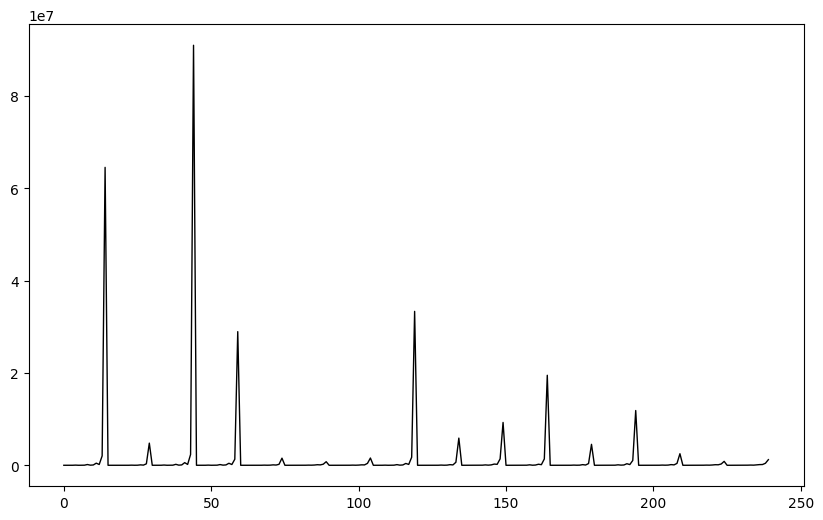

In [21]:
t = range(len(signal))
print(signal.shape)

plt.figure(figsize=(10,6))
plt.plot(t, signal, color = 'k', linewidth=1)
plt.show()

In [22]:
normal_dir = f"datasets/features/bispectrum/segment_{SEGMENT_TIME} seconds/normal_{LAG}"
signal = get_dummy(normal_dir)

datasets/features/bispectrum/segment_1 seconds/normal_256\omran\Omran_segment_715.csv_bispectrum.npy


(240,)


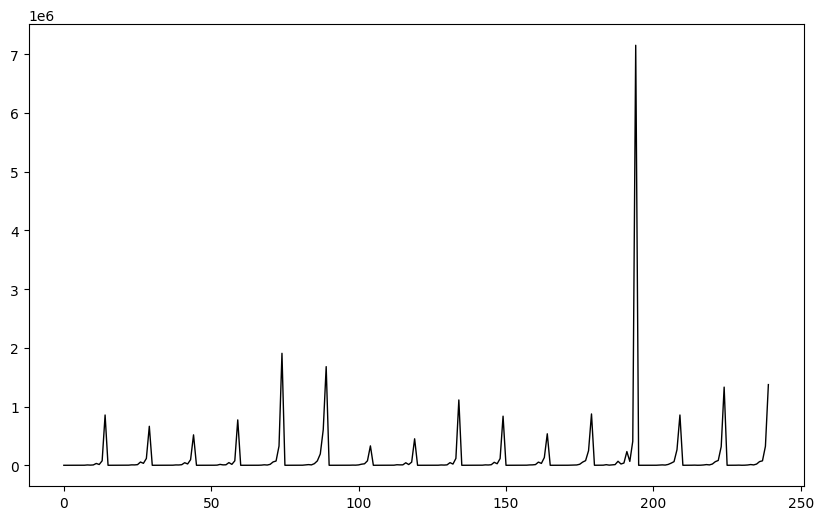

In [23]:
t = range(len(signal))
print(signal.shape)

plt.figure(figsize=(10,6))
plt.plot(t, signal, color = 'k', linewidth=1)
plt.show()

In [13]:
# signal = np.load('../Feature_FIX\Bispectrum2DFlat\Train\smni_cmi_train_bispectrum2dflat_256\co2a0000364\co2a0000364_0_bispectrum2dflat.npy')

#### Bispectrum: Pyramid Filter

In [24]:
autism_dir = f"datasets/features/bispectrum_pyramid/segment_{SEGMENT_TIME} seconds/autism_{LAG}"
signal = get_dummy(autism_dir)

datasets/features/bispectrum_pyramid/segment_1 seconds/autism_256\bader\Bader_segment_216.csv_bispectrum.npy


(240,)


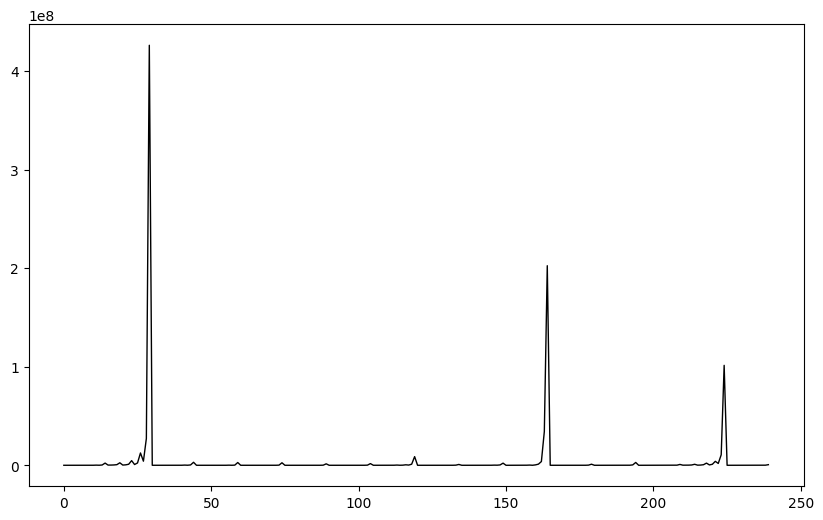

In [25]:
t = range(len(signal))
print(signal.shape)

plt.figure(figsize=(10,6))
plt.plot(t, signal, color = 'k', linewidth=1)
plt.show()

In [ ]:
normal_dir = f"datasets/features/bispectrum_pyramid/segment_{SEGMENT_TIME} seconds/normal_{LAG}"
signal = get_dummy(normal_dir)

In [ ]:
t = range(len(signal))
print(signal.shape)

plt.figure(figsize=(10,6))
plt.plot(t, signal, color = 'k', linewidth=1)
plt.show()

In [14]:
# signal = np.load('../Feature_FIX\Bispectrum2D\Train\smni_cmi_train_bispectrum2d_256\co2a0000364\co2a0000364_0_bispectrum2d.npy')

#### RWB

In [2]:
# Load the CSV file into a DataFrame

signal_256 = np.load('datasets/features/rwb/segment_1 seconds/autism_256/bader/Bader_segment_1031.csv_bispectrum.npy')
signal_128 = np.load('datasets/features/rwb/segment_1 seconds/autism_128/bader/Bader_segment_1031.csv_bispectrum.npy')
signal_64 = np.load('datasets/features/rwb/segment_1 seconds/autism_64/bader/Bader_segment_1031.csv_bispectrum.npy')
signal_32 = np.load('datasets/features/rwb/segment_1 seconds/autism_32/bader/Bader_segment_1031.csv_bispectrum.npy')
signal_16 = np.load('datasets/features/rwb/segment_1 seconds/autism_16/bader/Bader_segment_1031.csv_bispectrum.npy')
signal_8 = np.load('datasets/features/rwb/segment_1 seconds/autism_8/bader/Bader_segment_1031.csv_bispectrum.npy')
signal_4 = np.load('datasets/features/rwb/segment_1 seconds/autism_4/bader/Bader_segment_1031.csv_bispectrum.npy')
signal_2 = np.load('datasets/features/rwb/segment_1 seconds/autism_2/bader/Bader_segment_1031.csv_bispectrum.npy')

(96,)


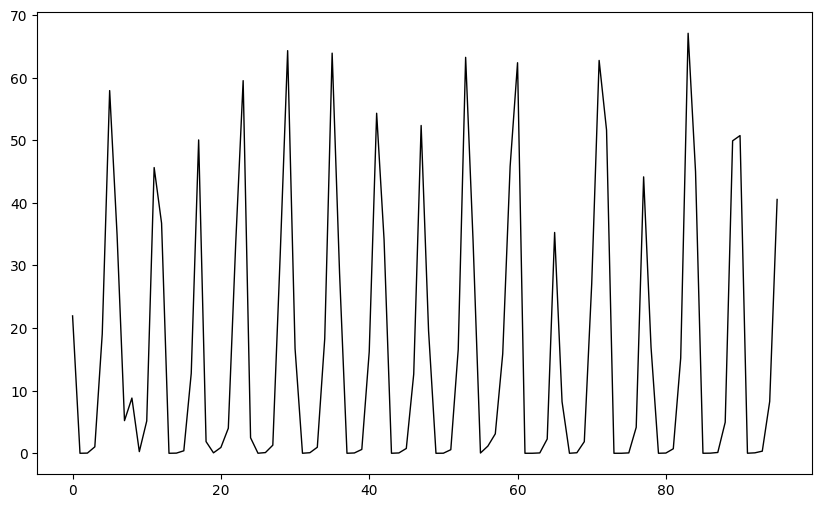

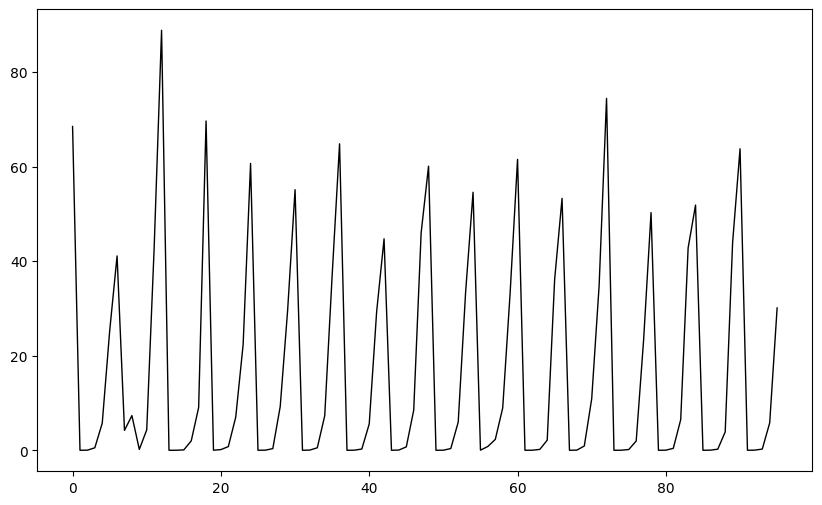

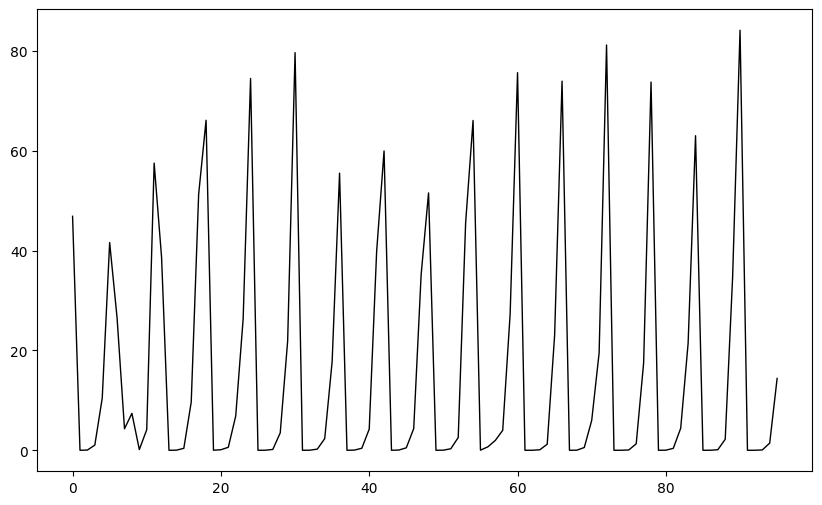

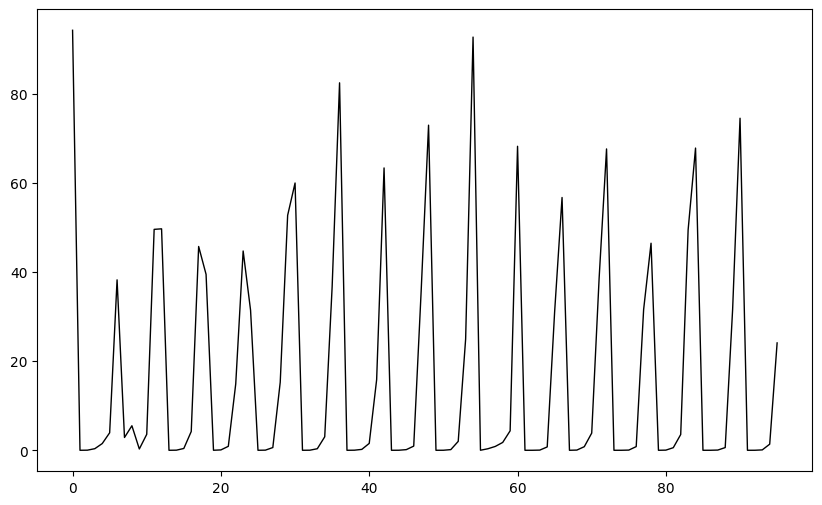

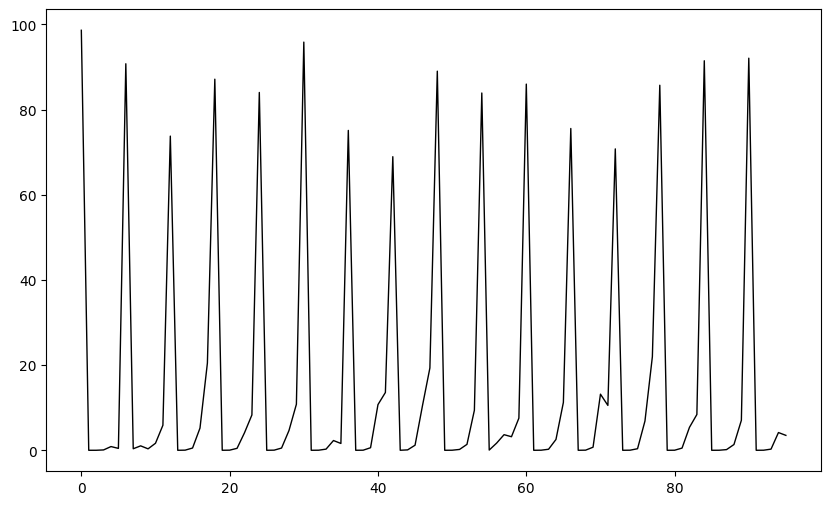

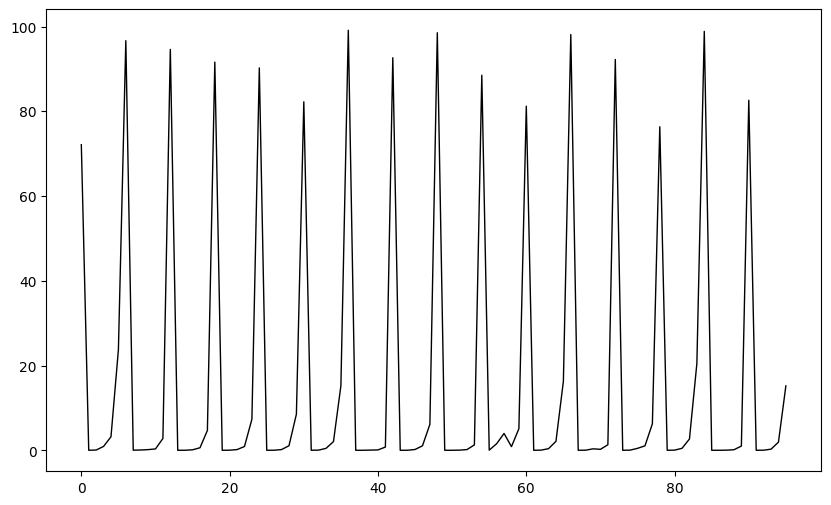

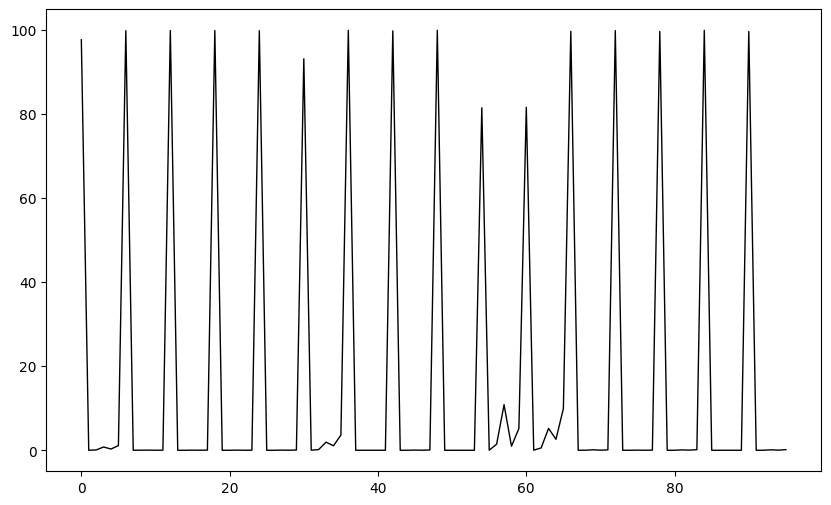

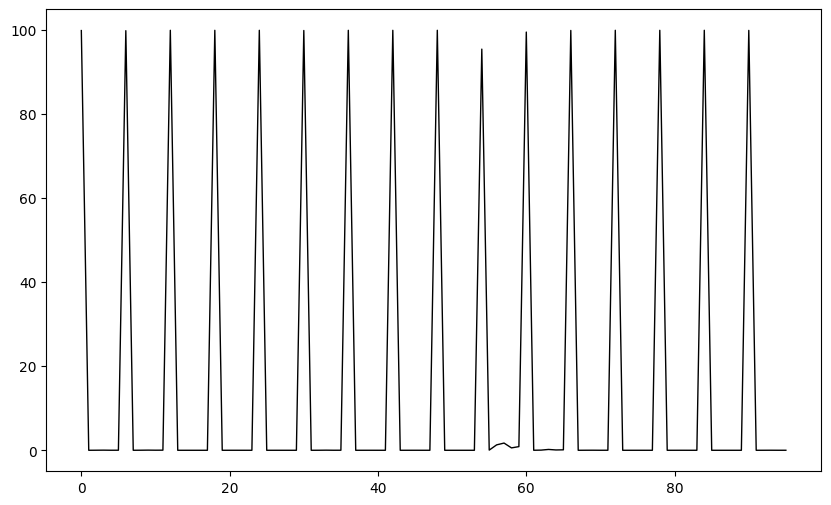

In [3]:
# Extract the signal values from the DataFrame
signals = [signal_256, signal_128, signal_64, signal_32, signal_16, signal_8, signal_4, signal_2]

# Create a time axis for the signal
t = range(len(signals[0]))
print(signals[0].shape)

for signal in signals:
    plt.figure(figsize=(10,6))
    plt.plot(t, signal, color = 'k', linewidth=1)
    plt.show()

#### RWB 2D

(16, 6)
range(0, 16)


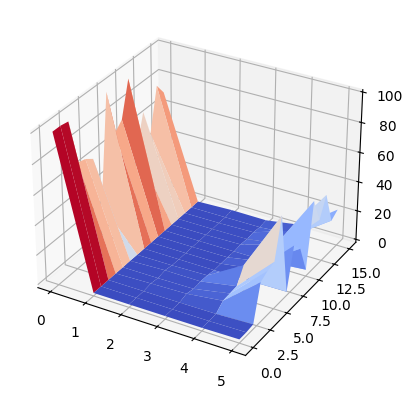

In [14]:

# signal = bis_256
# Extract the signal values from the DataFrame

# Create a time axis for the signal
t = range(len(signal_2d))
print(signal_2d.shape)
print(t)

# plt.figure(figsize=(10,6))
# plt.plot(t, signal_2d,  linewidth=1)
# plt.show()

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

x = np.arange(signal_2d.shape[1])
y = np.arange(signal_2d.shape[0])
x, y = np.meshgrid(x, y)
ax.plot_surface(x, y, signal_2d, cmap =cm.coolwarm)
# fig, axs = plt.subplots(len(signal_2d), figsize=(3, 10))
# fig.suptitle('2D RWB', fontsize=15)
# for i in range(len(signal_2d)):
#     axs[i].plot(t, signal_2d.T[i])
#     axs[i].axis('off')
plt.show()

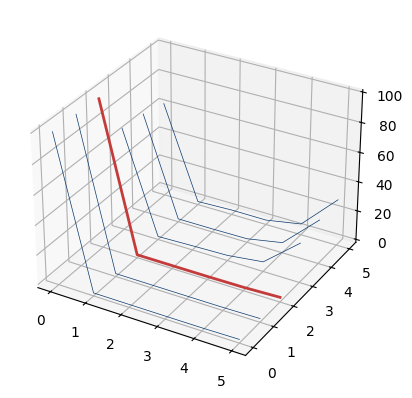

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Fixing random state for reproducibility
np.random.seed(19680801)


fig = plt.figure()
ax = fig.add_subplot(projection='3d')

colors = ['#09386D', '#09386D', '#C43B3C', '#09386D', '#09386D', '#09386D']
yticks = [0 , 1, 2, 3, 4, 5]
i = 0
line = 2
for c, k in zip(colors, yticks):
    # Generate the random data for the y=k 'layer'.
    xs = np.arange(len(signal_2d[i]))
    ys = signal_2d[i]

    # You can provide either a single color or an array with the same length as
    # xs and ys. To demonstrate this, we color the first bar of each set cyan.
    # cs = [c] * len(xs)
    # cs[0] = 'c'
    if k != 2:
        line = 0.5
    else:
        line = 2
    # Plot the bar graph given by xs and ys on the plane y=k with 80% opacity.
    ax.plot(xs, ys, zs=k, zdir='y', color=c, linewidth=line)
    # ax.fill_between(xs, 0, ys, alpha=0.5)
    i +=1

# On the y-axis let's only label the discrete values that we have data for.
ax.set_yticks(yticks)

plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


colors = ['#09386D', '#09386D', '#C43B3C', '#09386D', '#09386D', '#09386D']
yticks = [0 , 1, 2, 3, 4, 5]
i = 0
line = 2
for c, k in zip(colors, yticks):
    # FEATURE MATRIX
    x, y = np.meshgrid(np.arange(5), np.arange(5))
    z = signal[i]
    z = z[:-1, :-1]
    z_min, z_max = 0, np.abs(z).max()
    print(z_max)
    plt.subplot()

    plt.pcolormesh(x, y, z, 
                cmap =cm.coolwarm, 
                vmin = z_min, 
                vmax = z_max,
                edgecolors = 'face',
                shading ='flat')

    plt.title('Feature Matrix')

    # set the limits of the plot
    # to the limits of the data
    plt.axis([x.min(), x.max(), y.min(), y.max()])

    plt.colorbar()
    plt.show()
    i +=1
